In [1]:
!pip install -U torchtext==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Dataset

In [3]:
qa_dataset = [
    {
        "context": "Albert Einstein is very smart",
        "question": "Who is very smart",
        "answer": "Albert Einstein",
        "start_token": 0,
        "end_token": 1
    },
    {
        "context": "The forest cover over three thousand hectares",
        "question": "How much forest cover",
        "answer": "over three thousand hectares",
        "start_token": 3,
        "end_token": 6
    }
]

In [4]:
for sample in qa_dataset:
    print(f"Context: {sample['context']}")
    print(f"Question: {sample['question']}")
    print(f"Answer: {sample['answer']} (Start: {sample['start_token']}, End: {sample['end_token']})")
    print("-" * 50)

Context: Albert Einstein is very smart
Question: Who is very smart
Answer: Albert Einstein (Start: 0, End: 1)
--------------------------------------------------
Context: The forest cover over three thousand hectares
Question: How much forest cover
Answer: over three thousand hectares (Start: 3, End: 6)
--------------------------------------------------


# Preprocesing

In [13]:
from torchtext.data.utils import get_tokenizer
# Step 1: Tokenization
tokenizer = get_tokenizer("basic_english")

for sample in qa_dataset:
    sample["context_tokens"] = tokenizer(sample["context"])
    sample["question_tokens"] = tokenizer(sample["question"])

print("-" * 100)
for sample in qa_dataset:
    print(f"Context Tokens: {sample['context_tokens']}")
    print(f"Question Tokens: {sample['question_tokens']}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Context Tokens: ['albert', 'einstein', 'is', 'very', 'smart']
Question Tokens: ['who', 'is', 'very', 'smart']
----------------------------------------------------------------------------------------------------
Context Tokens: ['the', 'forest', 'cover', 'over', 'three', 'thousand', 'hectares']
Question Tokens: ['how', 'much', 'forest', 'cover']
----------------------------------------------------------------------------------------------------


In [14]:
# Step 2: Build Vocabulary
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(dataset):
    for sample in dataset:

        yield sample["context_tokens"]
        yield sample["question_tokens"]

# Define vocab size
vocab_size = 12

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(qa_dataset),
                                  max_tokens=vocab_size,
                                  specials=["<unk>", "<pad>", "<sep>", "<cls>"])
vocab.set_default_index(vocab["<unk>"])  # Set unknown token index

# Print vocabulary mappings
print("Vocabulary Mapping:")
print(vocab.get_stoi())

Vocabulary Mapping:
{'albert': 9, 'hectares': 11, 'very': 8, 'is': 6, 'forest': 5, 'cover': 4, '<cls>': 3, 'smart': 7, '<sep>': 2, 'einstein': 10, '<pad>': 1, '<unk>': 0}


In [15]:
# Step 3: Vectorization
def vectorize(tokens, vocab, sequence_length):
    token_ids = [vocab[token] for token in tokens][:sequence_length]
    token_ids += [vocab["<pad>"]] * (sequence_length - len(token_ids))  # Pad sequence
    return torch.tensor(token_ids, dtype=torch.long)

context_length = 5
question_length = 5

for sample in qa_dataset:
    sample["context_vector"] = vectorize(sample["context_tokens"], vocab, context_length)
    sample["question_vector"] = vectorize(sample["question_tokens"], vocab, question_length)
print("-" * 50)
for sample in qa_dataset:
    print(f"Context Vector: {sample['context_vector']}")
    print(f"Question Vector: {sample['question_vector']}")
    print("-" * 50)

--------------------------------------------------
Context Vector: tensor([ 9, 10,  6,  8,  7])
Question Vector: tensor([0, 6, 8, 7, 1])
--------------------------------------------------
Context Vector: tensor([0, 5, 4, 0, 0])
Question Vector: tensor([0, 0, 5, 4, 1])
--------------------------------------------------


# NLP model

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_length, question_length):
        super(SimpleMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)


        self.fc_start = nn.Linear(hidden_dim * 2, 1)  # Start token scores
        self.fc_end = nn.Linear(hidden_dim * 2, 1)    # End token scores

    def forward(self, input):
        input_emb = self.embedding(input)  # (batch, inputs_len, emb_dim)
        print(input_emb.shape)
        x, _ = self.lstm(input_emb)
        print(x.shape) # 1, 12, 256 : 12 tại vì : (context_length + context_length) + 1 token <cls> + 1 token <sep>. 256 tại vì bidirection nên 128 * 2
        start_scores = self.fc_start(x)  # Predict start positions
        end_scores = self.fc_end(x)      # Predict end positions
        return start_scores, end_scores

In [35]:
embedding_dim = 2
hidden_dim = 128
model = SimpleMLP(vocab_size, embedding_dim, hidden_dim, context_length, question_length)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [36]:
# Convert labels (start & end) to tensor
def get_labels(sample):
    return torch.tensor([sample["start_token"], sample["end_token"]], dtype=torch.float32)

In [37]:
for param in model.embedding.parameters():
    param.requires_grad = False

In [60]:
num_epochs = 1
for epoch in range(num_epochs):
    total_loss = 0
    for sample in qa_dataset:
        inputs = torch.cat([
            torch.tensor([vocab['<cls>']], dtype=torch.long),
            sample["context_vector"],
            torch.tensor([vocab['<sep>']], dtype=torch.long),
            sample["question_vector"]
        ], dim=0).unsqueeze(0)
        start_label, end_label = get_labels(sample)
        print(f"🔵 Start Label: {start_label}")
        print(f"🟣 End Label: {end_label}")

        optimizer.zero_grad()
        start_scores, end_scores = model(inputs)

        loss_start = loss_fn(start_scores.squeeze(-1).float(), start_label.unsqueeze(0).long())  # (N, C) , (N, 1)
        loss_end = loss_fn(end_scores.squeeze(-1).float(), end_label.unsqueeze(0).long())

        loss = loss_start + loss_end  # Combine both losses

        # loss.backward()
        # optimizer.step()

        total_loss += loss.item()

    if epoch == 0:
        print(f"📈 Epoch {epoch}, Loss: {total_loss:.4f}")

🔵 Start Label: 0.0
🟣 End Label: 1.0
torch.Size([1, 12, 2])
torch.Size([1, 12, 256])
🔵 Start Label: 3.0
🟣 End Label: 6.0
torch.Size([1, 12, 2])
torch.Size([1, 12, 256])
📈 Epoch 0, Loss: 9.9187


In [ ]:
import math
a = [ 0.4595, -0.6030, -1.1066, -0.5680,  0.0694]

b = [-0.1207,  0.0034,  1.0317, -1.4472,  0.9415]

rsa = []
rsb = []
for x in a:
    rsa.append(round(math.e**x, 4))
for x in b:
    rsb.append(round(math.e**x, 4))

print("a: " + str(rsa))
print(sum(rsa))
print("b: " + str(rsb))
print(sum(rsb))

softmaxa = []
softmaxb = []
for x in rsa:
    softmaxa.append(round(x/sum(rsa), 4))
for x in rsb:
    softmaxb.append(round(x/sum(rsb), 4))

print("a: " + str(softmaxa))
print("b: " + str(softmaxb))

a: [1.5833, 0.5472, 0.3307, 0.5667, 1.0719]
4.0998
b: [0.8863, 1.0034, 2.8058, 0.2352, 2.5638]
7.4945
a: [0.3862, 0.1335, 0.0807, 0.1382, 0.2615]
b: [0.1183, 0.1339, 0.3744, 0.0314, 0.3421]


# Illustrate

In [63]:
def visualize_scores(context, question, model, vocab, context_length):
    """Visualize start and end token scores."""
    context_tokens = tokenizer(context)
    question_tokens = tokenizer(question)

    inputs = torch.cat([
            torch.tensor([vocab['<cls>']], dtype=torch.long),
            sample["context_vector"],
            torch.tensor([vocab['<sep>']], dtype=torch.long),
            sample["question_vector"]
        ], dim=0).unsqueeze(0)

    with torch.no_grad():
        start_scores, end_scores = model(inputs)
        start_scores = start_scores.squeeze().numpy()
        end_scores = end_scores.squeeze().numpy()

    token_labels = [f"{i}" for i in range(len(start_scores))]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.bar(range(len(start_scores)), start_scores, color="blue", alpha=0.7)
    plt.xticks(range(len(start_scores)), token_labels, rotation=45, ha="right")
    plt.title("Start Token Scores")

    plt.subplot(2, 1, 2)
    plt.bar(range(len(end_scores)), end_scores, color="red", alpha=0.7)
    plt.xticks(range(len(end_scores)), token_labels, rotation=45, ha="right")
    plt.title("End Token Scores")

    plt.tight_layout()
    plt.show()

torch.Size([1, 12, 2])
torch.Size([1, 12, 256])


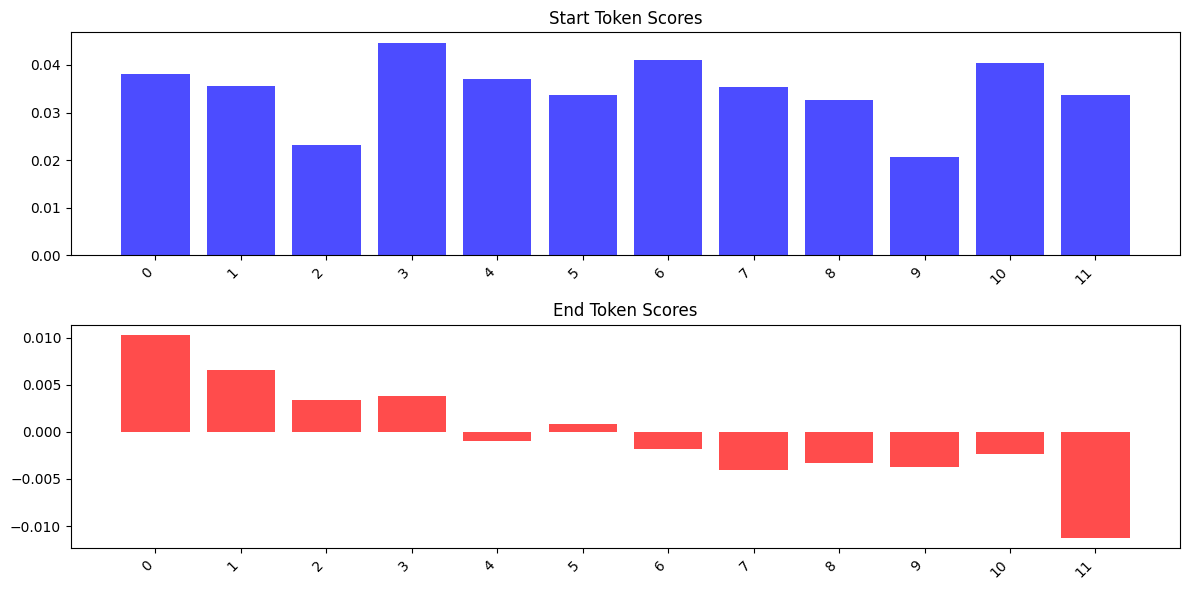

In [65]:
context = qa_dataset[0]["context"]
question = qa_dataset[0]["question"]
visualize_scores(context, question, model, vocab, context_length)

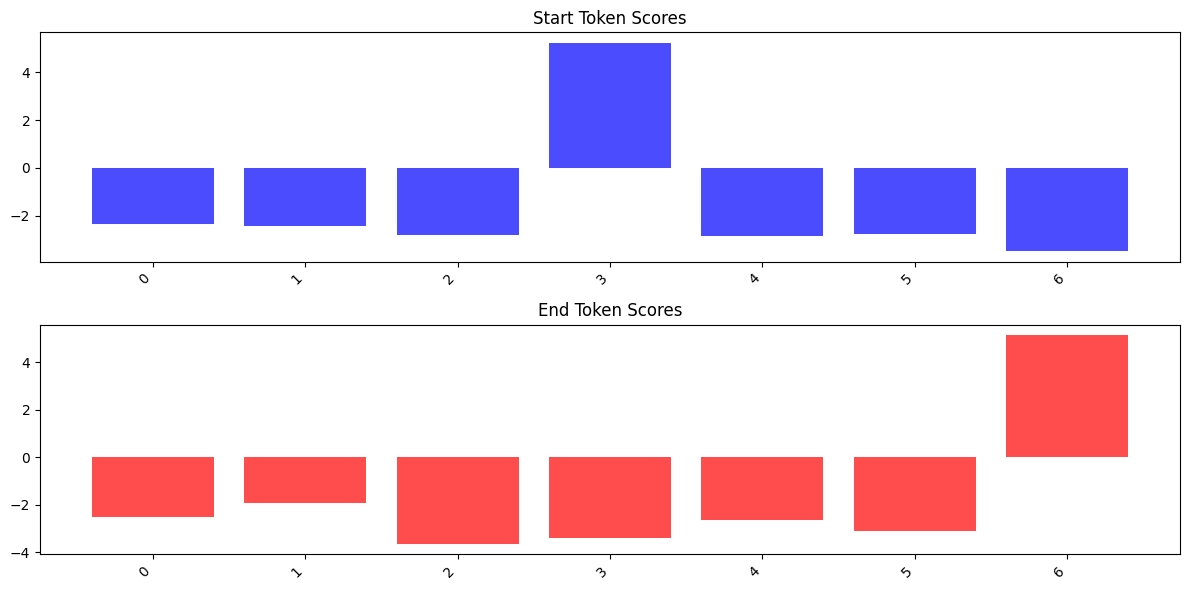

In [ ]:
context = qa_dataset[1]["context"]
question = qa_dataset[1]["question"]
visualize_scores(context, question, model, vocab, context_length)

**The problem is how can we deal with the end_token < the start_token during training**